In [1]:
import os, sys, inspect

cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)


cmd_subfolder = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],"lib/Leap")))
if cmd_subfolder not in sys.path:
    sys.path.insert(0, cmd_subfolder)
    cmd_subfolder = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],"lib/Anderson")))
if cmd_subfolder not in sys.path:
    sys.path.insert(0, cmd_subfolder)

In [2]:
import pandas as pd
import numpy as np
import neuralnetworks as nn
import mlutils as ml

In [3]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):
    import neuralnetworks as nn
    import mlutils as ml
    import numpy as np
    import time
    result = []
    for structure in hiddenLayerStructures:
        trainedResult = []
        testResult = []
        t0 = time.time()
        for n in range(0, numberRepetitions):
            Xtrain,Ttrain,Xtest,Ttest = ml.partition(X,T,(trainFraction, 1-trainFraction),classify)
            if classify:
                nnet = nn.NeuralNetworkClassifier(X.shape[1], structure, len(np.unique(T)))
                nnet.train(Xtrain, Ttrain, numberIterations, errorPrecision=1.e-8)
                trainedResult.append(np.sum(nnet.use(Xtrain)==Ttrain)/len(Ttrain))
                testResult.append(np.sum(nnet.use(Xtest)==Ttest)/len(Ttest))
            else:
                nnet = nn.NeuralNetwork(X.shape[1], structure, T.shape[1])
                nnet.train(Xtrain, Ttrain, numberIterations)
                trainedResult.append(np.sqrt(np.mean(((nnet.use(Xtrain)-Ttrain)**2))))
                testResult.append(np.sqrt(np.mean(((nnet.use(Xtest)-Ttest)**2))))

            
        result.append([structure, trainedResult, testResult, time.time() - t0])
    return result

def summarize(results):
    import numpy as np
    summaryResults = []
    for result in results:
        summaryResults.append([result[0], np.mean(result[1]), np.mean(result[2]), result[3]])
    return summaryResults


def bestNetwork(summary):
    best = min(summary, key=lambda l: l[2])
    return best


Dependencies/import config

## Get Data

In [4]:
data = pd.read_csv("templates/test.csv")
names = list(data)
data["signcode"] = data["sign"].astype('category').cat.codes
data = data.values

In [6]:
Xhands = data[:, 0:63]
Xhands = Xhands.astype(np.float64)

In [7]:
Tsign = data[:, 64:65]
Tsign = Tsign.astype(np.int32)

In [8]:
Xhands.shape

(106, 63)

In [9]:
Tsign.shape

(106, 1)

In [10]:
handNames = names[0:63]
signName = names[63]

In [22]:
for i in range(0, len(np.unique(Tsign).tolist())):
    print('{} samples in class {}'.format(np.sum(Tsign==i), i))

104 samples in class 0
2 samples in class 1


Get list of how many samples in each class/category/how many of each sign.

## Test NNet

In [12]:
results = trainNNs(Xhands, Tsign, 0.90, [[5,5], 5], 10, 100, classify=True)

In [13]:
results

[[[5, 5],
  [0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  0.6160788536071777],
 [5,
  [0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337,
   0.98958333333333337],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  0.5265674591064453]]

In [14]:
summarize(results)

[[[5, 5], 0.98958333333333337, 1.0, 0.6160788536071777],
 [5, 0.98958333333333337, 1.0, 0.5265674591064453]]

In [15]:
bestNet = bestNetwork(summarize(results))
bestNet

[[5, 5], 0.98958333333333337, 1.0, 0.6160788536071777]

## Plot the test

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

#run best on 
Xtrain,Ttrain,Xtest,Ttest = ml.partition(Xhands,Tsign,(0.8, 0.2),True)
nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1], bestNet[0], len(np.unique(Ttrain)))
nnet.train(Xtrain, Ttrain, 100)

NeuralNetwork(63, [5, 5], 2)
   Network was trained for 100 iterations. Final error is 0.031910832995494.

In [17]:
result = nnet.use(Xtest)

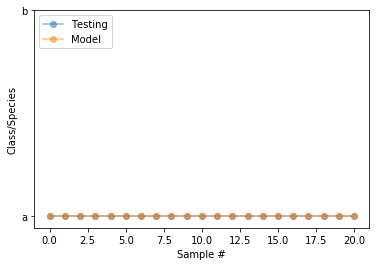

In [20]:
#plt.subplot(3, 1, 1)
plt.plot(Ttest, 'o-', alpha=0.5)
plt.plot(result, "o-", alpha=0.5)

labels = np.unique(data[:, 63])
plt.xlabel("Sample #")
plt.ylabel("Sign")

plt.yticks(np.unique(Ttest).tolist(), np.unique(labels).tolist())

plt.legend(('Testing','Model'), loc='upper left')

In [19]:
np.unique(Ttest).tolist()

[0]

vs

In [23]:
np.unique(Tsign).tolist()

[0, 1]

Numerical versions of the sign categories actually in the test data (may not include all of the categories in the dataset, since it's randomly sampled)